<a href="https://colab.research.google.com/github/aditya160108/SEO-Analysis/blob/main/ConsoleSetup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving client_secret_.json to client_secret_.json


{'client_secret_.json': b'{"installed":{"client_id":"129942088508-1a4et8b79lecfsp8jsrs8kkps7pe04j7.apps.googleusercontent.com","project_id":"searchconsoleapp-408906","auth_uri":"https://accounts.google.com/o/oauth2/auth","token_uri":"https://oauth2.googleapis.com/token","auth_provider_x509_cert_url":"https://www.googleapis.com/oauth2/v1/certs","client_secret":"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","redirect_uris":["http://localhost"]}}'}

In [ ]:
%%capture
!pip install git+https://github.com/joshcarty/google-searchconsole
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import data_table
!pip install umap-learn
data_table.enable_dataframe_formatter()

In [ ]:
import searchconsole
account = searchconsole.authenticate(client_config='client_secret_.json',serialize='credentials.json', flow='console')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=129942088508-1a4et8b79lecfsp8jsrs8kkps7pe04j7.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fwebmasters.readonly&state=BDYSYUScnSmLwPKwIW8vpftIQe4gCb&prompt=consent&access_type=offline
Enter the authorization code: 4/1AfJohXnzVe7KNRfQTj0c1HEnY-J2pGFlYYDFgre8YkHx5Wo5XXYH25lY6dQ


In [ ]:
property_name = input('Insert the name of your website as listed in GSC: ')
webproperty=account[str(property_name)]

Insert the name of your website as listed in GSC: https://www.encstore.com/


In [ ]:
def extract_gsc_data(webproperty, start, stop, *args):
 if webproperty is not None:
   print(f'Extracting data for {webproperty}')
   gsc_data = webproperty.query.range(start, stop).dimension(*args).get()
   return gsc_data
 else:
   print('Webproperty not found, please select the correct one')
   return None

In [ ]:
from datetime import datetime

ex = extract_gsc_data(webproperty, '2023-12-01', str(datetime.now().date()), 'query', 'page', 'date')

Extracting data for <searchconsole.account.WebProperty(url='https://www.encstore.com/')>


In [ ]:
df = pd.DataFrame(data=ex)
df.head()

,query,page,date,clicks,impressions,ctr,position
0,different types of security tags and how to re...,https://www.encstore.com/blog/5253-different-t...,2023-12-18,6,261,0.022989,7.831418
1,different types of security tags and how to re...,https://www.encstore.com/blog/5253-different-t...,2023-12-19,5,250,0.020000,7.208000
2,different types of security tags and how to re...,https://www.encstore.com/blog/5253-different-t...,2023-12-06,4,184,0.021739,7.168478
3,different types of security tags and how to re...,https://www.encstore.com/blog/5253-different-t...,2023-12-17,4,326,0.012270,8.134969
4,advantages and disadvantages of barcode reader,https://www.encstore.com/blog/5041-advantages-...,2023-12-12,3,4,0.750000,4.000000


In [ ]:
from google.colab import files
today_date = datetime.today().strftime('%Y-%m-%d')
filename = f'initialdataset_{today_date}.csv'
df.to_csv(filename, index=False)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
domain_name = str(input('Insert brand terms separated by a comma: ')).replace(',', '|')
import re
domain_name = re.sub(r"\s+", "", domain_name)
print('Remove all spaces using RegEx:\n')
df['Brand/Non-branded'] = np.where(
   df['query'].str.contains(domain_name), 'Brand', 'Non-branded'
)

Insert brand terms separated by a comma: encstore, enc store, perfect, enc
Remove all spaces using RegEx:



In [ ]:
brand_count_df = df['Brand/Non-branded'].value_counts().rename_axis('category').to_frame('counts')
brand_count_df['Percentage'] = brand_count_df['counts']/sum(brand_count_df['counts'])
pd.options.display.float_format = '{:.2%}'.format
brand_count_df

,counts,Percentage
category,,
Non-branded,419236,97.46%
Brand,10911,2.54%


In [ ]:
df.fillna(0, inplace = True)

In [ ]:
df['position'] = df['position'].round(0).astype('int64')

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [ ]:
ranking_queries = df.pivot_table(index=['position'], values=['query'], aggfunc=['count'])
ranking_queries.sort_values(by=['position']).head(10)

,count
,query
position,
1,44516
2,10096
3,12741
4,11878
5,9105
6,8685
7,6612
8,7472


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

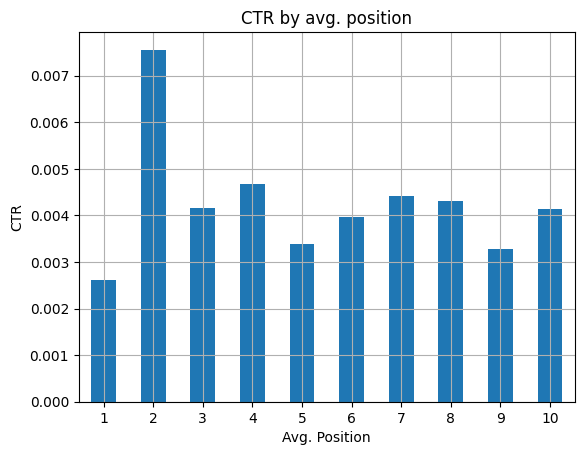

In [ ]:
pd.options.display.float_format = '{:.2%}'.format
query_analysis = df.pivot_table(index=['position'], values=['ctr'], aggfunc=['mean'])
query_analysis.sort_values(by=['position'], ascending=True).head(10)
ax = query_analysis.head(10).plot(kind='bar')
ax.set_xlabel('Avg. Position')
ax.set_ylabel('CTR')
ax.set_title('CTR by avg. position')
ax.grid('on')
ax.get_legend().remove()
plt.xticks(rotation=0)
plot1 = f'CTR_AVGPOSITION_{today_date}.png'
plt.savefig(plot1)
files.download(plot1)
plt.show()

In [ ]:
filename1 = f'ctr_avgposition_{today_date}.xlsx'
query_analysis.to_excel(filename1)
files.download(filename1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
clicks_sum = df.groupby('date')['clicks'].sum()

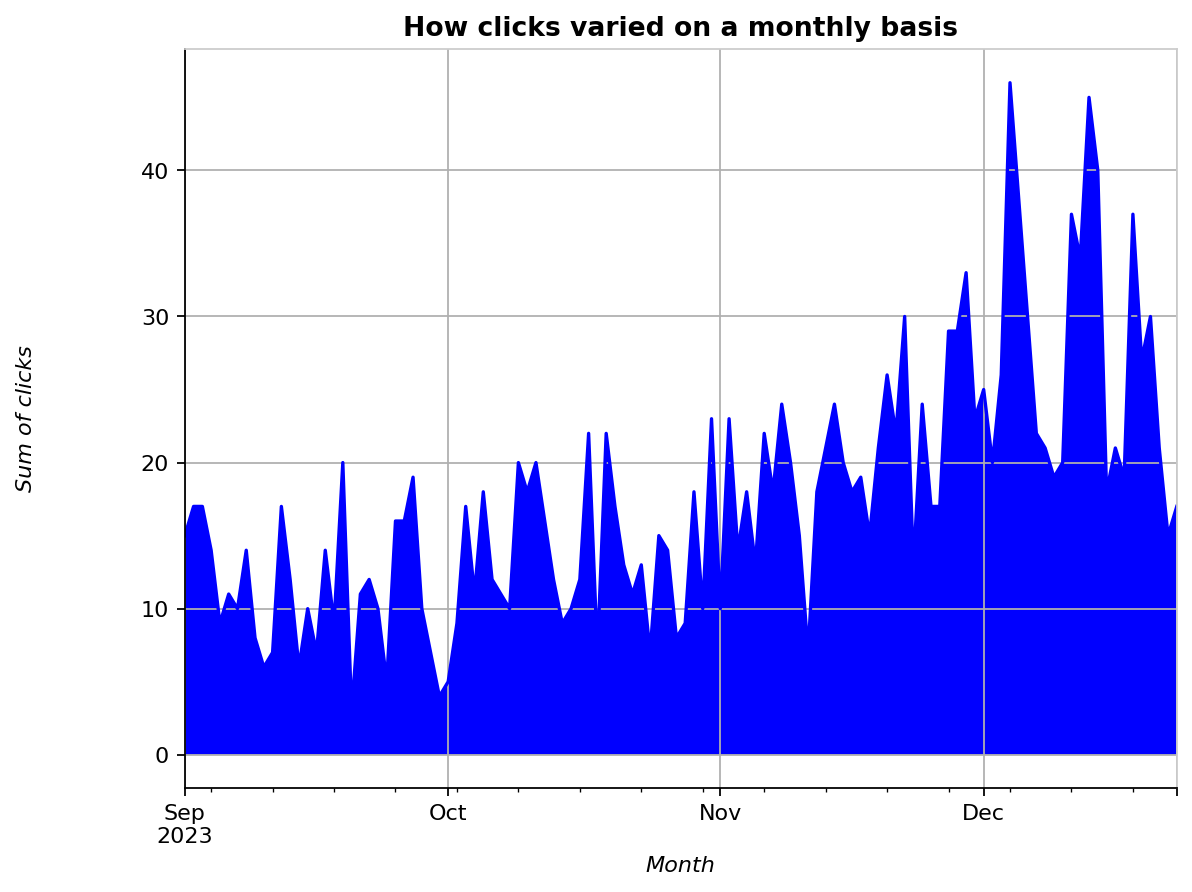

In [ ]:
%config InlineBackend.figure_format = 'retina'
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
ax = clicks_sum.plot(color='blue')
ax.grid('on')
ax.set_ylabel('Sum of clicks')
ax.set_xlabel('Month')
ax.set_title('How clicks varied on a monthly basis')
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(10)
ylab.set_style('italic')
ylab.set_size(10)
ttl = ax.title
ttl.set_weight('bold')
ax.spines['right'].set_color((.8,.8,.8))
ax.spines['top'].set_color((.8,.8,.8))
ax.yaxis.set_label_coords(-.15, .50)
ax.fill_between(clicks_sum.index, clicks_sum.values, facecolor='blue')

In [ ]:
filename2 = f'clicks_month_{today_date}.xlsx'
clicks_sum.to_excel(filename2,index=False)
files.download(filename2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, '1'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '3'),
  Text(0, 3.5, '4'),
  Text(0, 4.5, '5'),
  Text(0, 5.5, '6'),
  Text(0, 6.5, '7'),
  Text(0, 7.5, '8'),
  Text(0, 8.5, '9'),
  Text(0, 9.5, '10')])

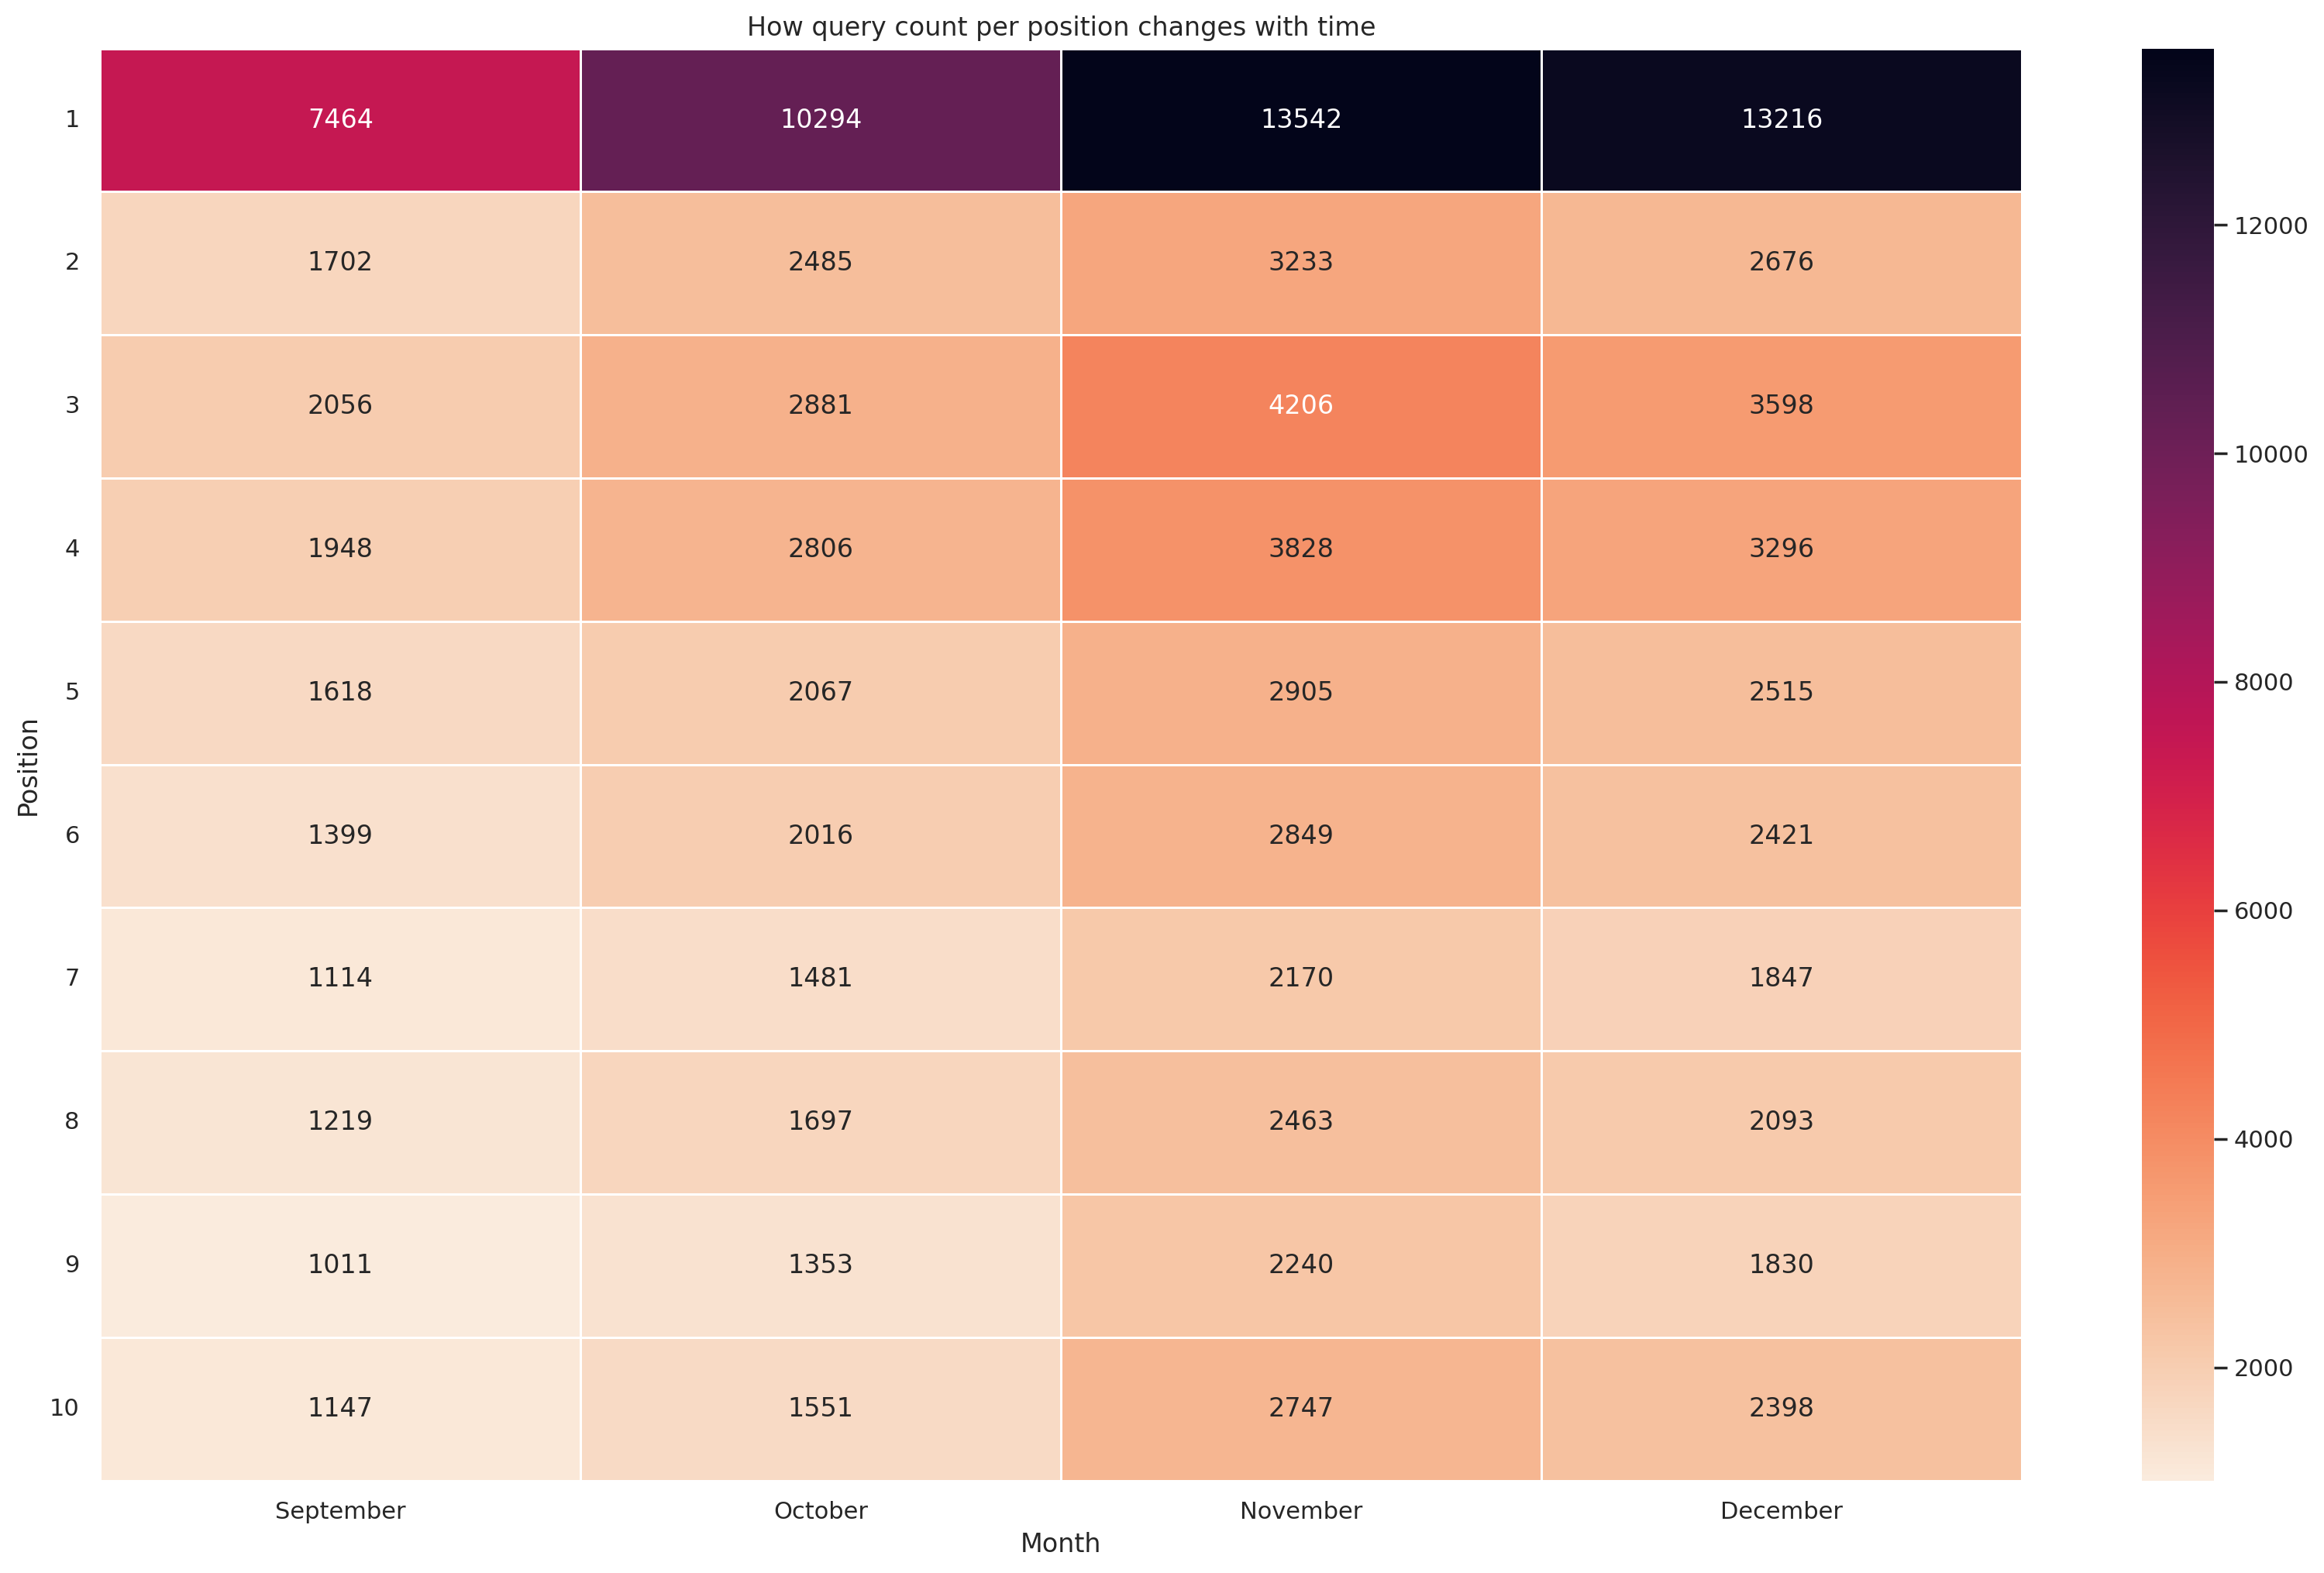

In [ ]:
import seaborn as sns
sns.set_theme()

df_new = df.loc[(df['position'] <= 10) & (df['year'] != 2024),:]

df_heat = df_new.pivot_table(index = "position", columns = "month", values = "query", aggfunc='count')

f, ax = plt.subplots(figsize=(20, 12))

unique_months = sorted(df['date'].dt.strftime('%B').unique(), key=lambda x: datetime.strptime(x, '%B'))

x_axis_labels = unique_months

sns.heatmap(df_heat, annot=True, linewidths=.5, ax=ax, fmt='g', cmap = sns.cm.rocket_r, xticklabels=x_axis_labels)
ax.set(xlabel = 'Month', ylabel='Position', title = 'How query count per position changes with time')
plt.yticks(rotation=0)

In [ ]:
filename3 = f'heatmap_data_{today_date}.xlsx'
df_heat.to_excel(filename3,index=False)
files.download(filename3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
ngrams = c_vec.fit_transform(df['query'])
count_values = ngrams.toarray().sum(axis=0)
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
           ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

df_ngram.head(20).style.background_gradient()

In [ ]:
filename4 = f'ngram_data_{today_date}.xlsx'
df_ngram.to_excel(filename4,index=False)
files.download(filename4)

In [ ]:
top_impressions = df[df['impressions'] >= df['impressions'].quantile(0.8)]
(top_impressions[top_impressions['ctr'] <= top_impressions['ctr'].quantile(0.2)].sort_values('impressions', ascending = False))

In [ ]:
filename5 = f'top_impressions_data{today_date}.xlsx'
top_impressions.to_excel(filename5,index=False)
files.download(filename5)

In [ ]:
!pip install mlxtend

from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import LabelEncoder

In [ ]:
df['date'] = pd.to_datetime(df['date'])


In [ ]:
queries = df['query'].apply(lambda x: re.split(r'[“?^”<#(/\]=\-):[@÷\'&",’$.•⁄_+ ]', x))

te = TransactionEncoder()
te_ary = te.fit(queries).transform(queries)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)

print(frequent_itemsets)

In [ ]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

#print(rules)
filenamerules = f'associationrule{today_date}.xlsx'
rules.to_excel(filenamerules, index=False)
files.download(filenamerules)